# Salinity in B-SOSE: compute fronts

In [ ]:
# Not needed for B-SOSE

# tell Python to use the ecco_v4_py in the 'ECCOv4-py' repository
from os.path import join,expanduser
import sys

# identify user's home directory
user_home_dir = expanduser('~')

# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco

import botocore  
import boto3
from boto3.session import Session

import s3fs

In [ ]:
import cmocean
from collections import Counter
from dask.distributed import Client
import datetime
import fsspec
from gc import get_referents
import json
import numpy as np
from pathlib import Path
from pprint import pprint
import requests

import sys
from sys import getsizeof
import time as time
from types import ModuleType, FunctionType
import xarray as xr
import matplotlib.pyplot as plt
import zarr

import numpy as np
import pandas as pd
import calendar
import gsw
#import warnings

In [ ]:
#warnings.filterwarnings("ignore")

In [ ]:
from dask.distributed import Client

#  connec to existing LocalCluster
# the port number will be different!
client = Client("tcp://127.0.0.1:42155")
client.ncores
client.restart()

In [3]:
# function for determining the memory footprint of an object

# ... from https://stackoverflow.com/questions/449560/how-do-i-determine-the-size-of-an-object-in-python

# Custom objects know their class.
# Function objects seem to know way too much, including modules.
# Exclude modules as well.
BLACKLIST = type, ModuleType, FunctionType

def getsize(obj):
    """
    This routine returns the in-memory size of an python object
    
    Returns:
    =======
    
    size: size of object & members.
    """
    if isinstance(obj, BLACKLIST):
        raise TypeError('getsize() does not take argument of type: '+ str(type(obj)))
    seen_ids = set()
    size = 0
    objects = [obj]
    while objects:
        need_referents = []
        for obj in objects:
            if not isinstance(obj, BLACKLIST) and id(obj) not in seen_ids:
                seen_ids.add(id(obj))
                size += sys.getsizeof(obj)
                need_referents.append(obj)
        objects = get_referents(*need_referents)
    return size

In [46]:
# Plotting settings

plt.rcParams['figure.figsize'] = (10, 3)

In [5]:
# local path to monthly-mean MLD dataset
bsose_path = Path('/efs_ecco/alopicco/bsose_data/')

# make a list of all of the files in the directory
bsose_files = np.sort(list(bsose_path.glob('*nc')))

# show first 10 files
print('\nFirst 10 files')
pprint([x.name for x in bsose_files[:10]])


First 10 files
['ADVr_SLT_bsoseI156_2013to2024_monthly.nc',
 'ADVr_TH_bsoseI156_2013to2024_monthly.nc',
 'MLD_bsoseI156_2013to2024_monthly.nc',
 'Salt_bsoseI156_2013to2024_monthly.nc',
 'Theta_bsoseI156_2013to2024_monthly.nc',
 'WVELSLT_bsoseI156_2013to2024_monthly.nc',
 'WVELTH_bsoseI156_2013to2024_monthly.nc',
 'grid.nc']


In [6]:
# local path to monthly-mean MLD dataset
bsose_path = Path('/efs_ecco/alopicco/bsose_data/')

# make a list of all of the files in the directory
bsose_files = np.sort(list(bsose_path.glob('*nc')))

# show first 5 files
print('\nFirst 5 files')
pprint([x.name for x in bsose_files[:5]])

# open dataset
MLD_file = bsose_path / 'MLD_bsoseI156_2013to2024_monthly.nc'
salt_file = bsose_path / 'Salt_bsoseI156_2013to2024_monthly.nc'
grid_file = bsose_path / 'grid.nc'

print(f'\nfile to open --> {MLD_file.name}')
print(f'\nfile to open --> {salt_file.name}')
print(f'\nfile to open --> {grid_file.name}')


First 5 files
['ADVr_SLT_bsoseI156_2013to2024_monthly.nc',
 'ADVr_TH_bsoseI156_2013to2024_monthly.nc',
 'MLD_bsoseI156_2013to2024_monthly.nc',
 'Salt_bsoseI156_2013to2024_monthly.nc',
 'Theta_bsoseI156_2013to2024_monthly.nc']

file to open --> MLD_bsoseI156_2013to2024_monthly.nc

file to open --> Salt_bsoseI156_2013to2024_monthly.nc

file to open --> grid.nc


In [7]:
# start timer
start_time = time.time()

# load the file into memory (note 'load' command at the end)
ds = xr.open_dataset(salt_file)
MLD_ds = xr.open_dataset(MLD_file)
grid_ds = xr.open_dataset(grid_file)

# stop timer
total_time = time.time() - start_time

print('\nloaded theta')
print(f'total time {total_time:.2f} sec')
print('time level : ' , ds.time.values[0])

# show contents of single granule
ds


loaded theta
total time 1.39 sec
time level :  2013-01-30T20:00:00.000000000


<xarray.Dataset> Size: 38GB
Dimensions:  (time: 144, XC: 2160, YC: 588, Z: 52)
Coordinates: (12/14)
    iter     (time) int64 1kB ...
  * time     (time) datetime64[ns] 1kB 2013-01-30T20:00:00 ... 2024-12-28T10:...
  * XC       (XC) float32 9kB 0.08333 0.25 0.4167 0.5833 ... 359.6 359.8 359.9
  * YC       (YC) float32 2kB -77.98 -77.95 -77.91 ... -30.02 -29.87 -29.72
  * Z        (Z) float32 208B -2.1 -6.7 -12.15 ... -5e+03 -5.4e+03 -5.8e+03
    rA       (YC, XC) float32 5MB ...
    ...       ...
    hFacC    (Z, YC, XC) float32 264MB ...
    maskC    (Z, YC, XC) bool 66MB ...
    maskInC  (YC, XC) bool 1MB ...
    rhoRef   (Z) float32 208B ...
    rSurfC   (YC, XC) float32 5MB ...
    rLowC    (YC, XC) float32 5MB ...
Data variables:
    SALT     (time, Z, YC, XC) float32 38GB ...

### Monthly Salinity

In [11]:
# Monthly salinity
st = time.time()

SSS = np.full((ds.dims['time'],ds.dims['YC'],ds.dims['XC']),np.nan)
              
for ti in range(ds.dims['time']):
    salt = ds.SALT.isel(time=ti)
    SSS[ti] = np.where(ds.maskC.isel(Z=0),salt.isel(Z=0),np.nan)

total_time = time.time() - st
print(f'total time to compute the mean temperature {total_time:.3g}s')

/tmp/ipykernel_1571/1807544539.py:4: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  SSS = np.full((ds.dims['time'],ds.dims['YC'],ds.dims['XC']),np.nan)
/tmp/ipykernel_1571/1807544539.py:6: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for ti in range(ds.dims['time']):


total time to compute the mean temperature 3.75s


In [12]:
# Find frontal regions for SSS

# Get x and y coordinate arrays
x = ds.XC  # shape (nx,)
y = ds.YC  # shape (ny,)

# Compute spacing
dx = np.gradient(x)  # shape (nx,)
dy = np.gradient(y)  # shape (ny,)

# Broadcast dx and dy to match SST shape
DX, DY = np.meshgrid(dx, dy)

# Compute SSS gradient
dSSS_dx = np.gradient(SSS, axis=2) / DX
dSSS_dy = np.gradient(SSS, axis=1) / DY

# Gradient magnitude
grad_SSS = np.sqrt(dSSS_dx**2 + dSSS_dy**2)

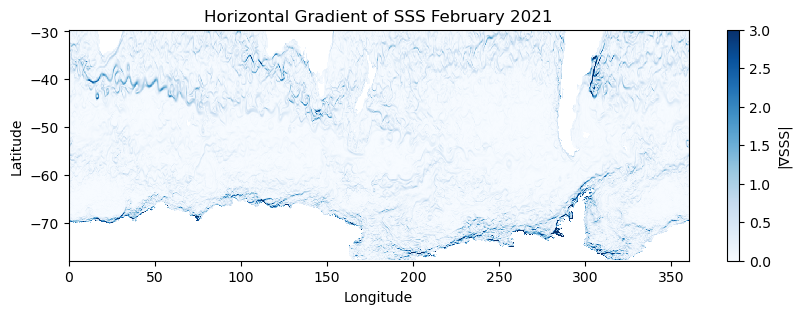

In [47]:
XCc, YCc = np.meshgrid(x, y)

plt.figure()

ti=97
time_str = pd.to_datetime(ds.time[ti].values).strftime('%B %Y')

vmin = 0
vmax = 3
plt.pcolormesh(XCc, YCc, grad_SSS[ti,:,:], shading='auto', vmin=vmin, vmax=vmax, cmap='Blues')
plt.colorbar(label='|∇SSS|')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Horizontal Gradient of SSS {time_str}')

plt.show()

### Time avg SSS

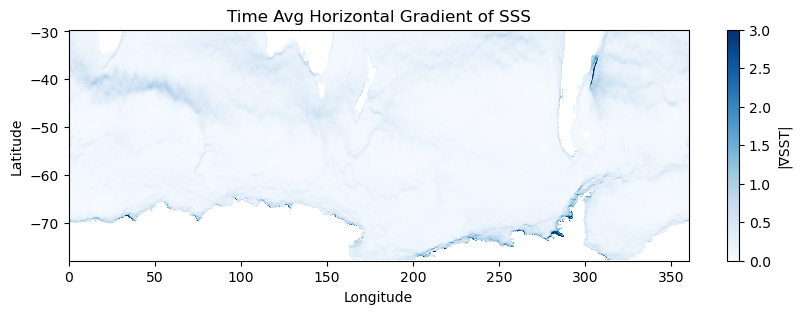

In [48]:
# Time avg SSS gradient
grad_SSS_avg = grad_SSS.mean(axis=0)

plt.figure()

vmin = 0
vmax = 3
plt.pcolormesh(XCc, YCc, grad_SSS_avg, shading='auto', vmin=vmin, vmax=vmax, cmap='Blues')
plt.colorbar(label='|∇SST|')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Time Avg Horizontal Gradient of SSS')

plt.show()

### SSS Climatology

In [23]:
# Create climatology for SSS

# Wrap gradient array into DataArray
grad_SSS_da = xr.DataArray(
    grad_SSS,
    coords={"time": ds.time, "YC": ds.YC, "XC": ds.XC},
    dims=["time", "YC", "XC"]
)

# Group by month and compute climatology (mean for each month)
grad_SSS_clim = grad_SSS_da.groupby("time.month").mean("time")

# Replace numeric months (1-12) with abbreviated names ('Jan', 'Feb', ...)
month_names = [calendar.month_abbr[m] for m in grad_SSS_clim["month"].values]
grad_SSS_clim = grad_SSS_clim.assign_coords(month=("month", month_names))

In [24]:
grad_SSS_clim['month']

<xarray.DataArray 'month' (month: 12)> Size: 144B
array(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
       'Nov', 'Dec'], dtype='<U3')
Coordinates:
  * month    (month) <U3 144B 'Jan' 'Feb' 'Mar' 'Apr' ... 'Oct' 'Nov' 'Dec'

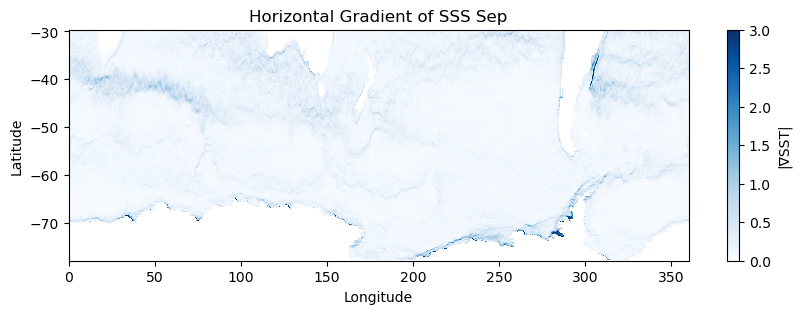

In [49]:
plt.figure()

mm=8
month_str = grad_SSS_clim["month"].values[mm]

vmin = 0
vmax = 3
plt.pcolormesh(XCc, YCc, grad_SSS_clim[mm,:,:], shading='auto', vmin=vmin, vmax=vmax, cmap='Blues')
plt.colorbar(label='|∇SST|')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Horizontal Gradient of SSS {month_str}')

plt.show()

### ML salinity

In [27]:
salt_ML = np.full((ds.dims['time'],ds.dims['YC'],ds.dims['XC']),np.nan)
              
for ti in range(ds.dims['time']):
    MLD_t = MLD_ds.BLGMLD.isel(time=ti)
    salt_t = ds.SALT.isel(time=ti)
    salt_ML_t = np.mean(salt_t.where((-ds.Z<MLD_t)),axis=0)
    salt_ML[ti,:,:] = np.where(ds.maskInC,salt_ML_t,np.nan)

/tmp/ipykernel_1571/3620738147.py:1: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  salt_ML = np.full((ds.dims['time'],ds.dims['YC'],ds.dims['XC']),np.nan)
/tmp/ipykernel_1571/3620738147.py:3: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for ti in range(ds.dims['time']):


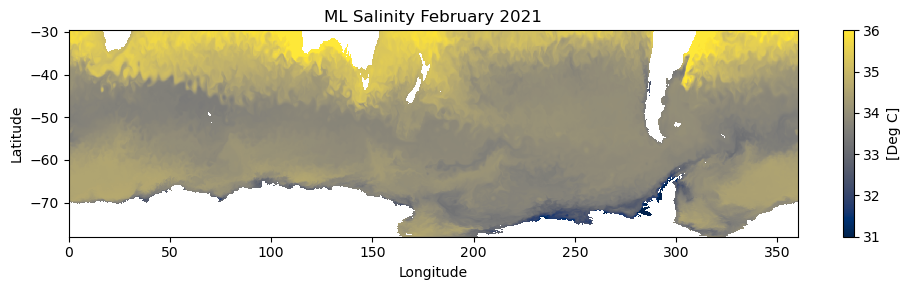

In [50]:
plt.figure()

ti=97 # feb 2021
#ti=104 # sept 2021
#var = theta_ML[ti,:,:]-SST[ti,:,:]
var = salt_ML[ti,:,:]

time_str = pd.to_datetime(ds.time[ti].values).strftime('%B %Y')

vmin = 31
vmax = 36
plt.pcolormesh(ds.XC, ds.YC, var, shading='auto', vmin=vmin, vmax=vmax, cmap='cividis')
plt.colorbar(label='[Deg C]')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'ML Salinity {time_str}')
plt.tight_layout()

plt.show()

### Gradients in ML salinity

In [34]:
# Find frontal regions for ML temperature

# Get x and y coordinate arrays
x = ds.XC  # shape (nx,)
y = ds.YC  # shape (ny,)

# Compute spacing
dx = np.gradient(x)  # shape (nx,)
dy = np.gradient(y)  # shape (ny,)

# Broadcast dx and dy to match SST shape
DX, DY = np.meshgrid(dx, dy)

# Compute SST gradient
dsaltML_dx = np.gradient(salt_ML, axis=2) / DX
dsaltML_dy = np.gradient(salt_ML, axis=1) / DY

# Gradient magnitude
grad_saltML = np.sqrt(dsaltML_dx**2 + dsaltML_dy**2)

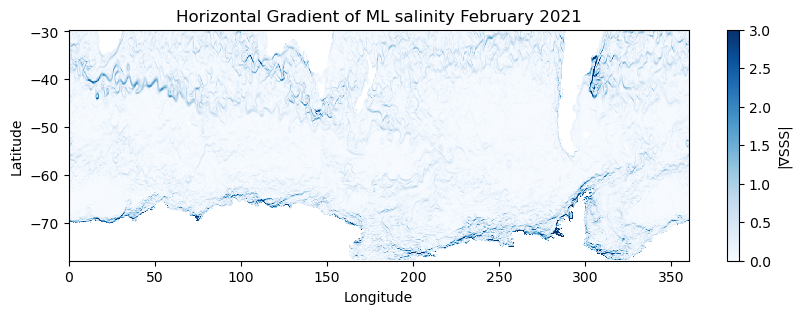

In [51]:
XCc, YCc = np.meshgrid(x, y)

plt.figure()

ti=97 # feb 2021
#ti=104 # sept 2021
time_str = pd.to_datetime(ds.time[ti].values).strftime('%B %Y')

var = grad_saltML[ti,:,:]
#var = grad_thetaML[ti,:,:]-grad_SST[ti,:,:]

vmin = 0
vmax = 3
plt.pcolormesh(XCc, YCc, var, shading='auto', vmin=vmin, vmax=vmax, cmap='Blues')
plt.colorbar(label='|∇SSS|')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Horizontal Gradient of ML salinity {time_str}')

plt.show()

### ML salinity gradient climatology

In [36]:
# Wrap gradient array into DataArray
grad_saltML_da = xr.DataArray(
    grad_saltML,
    coords={"time": ds.time, "YC": ds.YC, "XC": ds.XC},
    dims=["time", "YC", "XC"]
)

# Group by month and compute climatology (mean for each month)
grad_saltML_clim = grad_saltML_da.groupby("time.month").mean("time")

# Replace numeric months (1-12) with abbreviated names ('Jan', 'Feb', ...)
month_names = [calendar.month_abbr[m] for m in grad_saltML_clim["month"].values]
grad_saltML_clim = grad_saltML_clim.assign_coords(month=("month", month_names))

### Winter and summer climatology of ML temperature gradient 

In [37]:
# Winter months: JAS
# Summer months: DJF

grad_saltML_winter = grad_saltML_clim.sel(month=["Jul", "Aug", "Sep"]).mean(dim='month')
grad_saltML_summer = grad_saltML_clim.sel(month=["Dec", "Jan", "Feb"]).mean(dim='month')

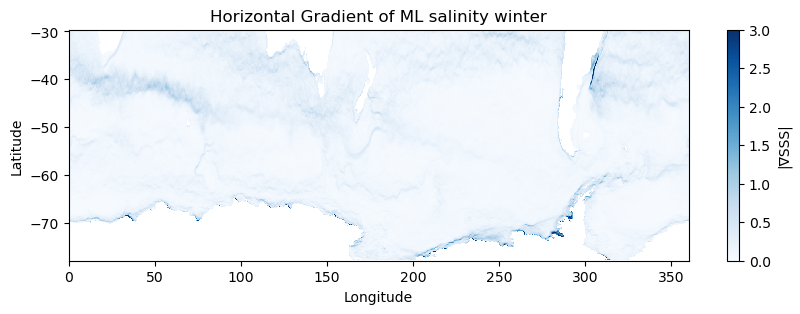

In [52]:
plt.figure()

time_str = pd.to_datetime(ds.time[ti].values).strftime('%B %Y')

var = grad_saltML_winter

vmin = 0
vmax = 3
plt.pcolormesh(XCc, YCc, var, shading='auto', vmin=vmin, vmax=vmax, cmap='Blues')
plt.colorbar(label='|∇SSS|')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Horizontal Gradient of ML salinity winter')

plt.show()

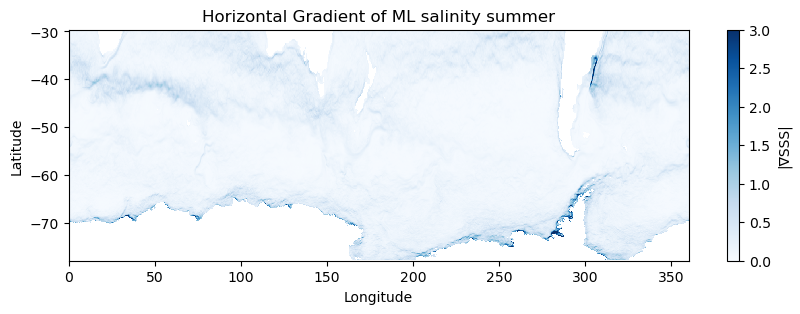

In [53]:
plt.figure()

time_str = pd.to_datetime(ds.time[ti].values).strftime('%B %Y')

var = grad_saltML_summer

vmin = 0
vmax = 3
plt.pcolormesh(XCc, YCc, var, shading='auto', vmin=vmin, vmax=vmax, cmap='Blues')
plt.colorbar(label='|∇SSS|')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Horizontal Gradient of ML salinity summer')

plt.show()